<a href="https://colab.research.google.com/github/kayleepho/MATH-5750-Project-1/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Math 5750/6880: Mathematics of Data Science \\
Project 1

# 3. Python and Google Colab
Project Euler Problem  
https://projecteuler.net/

**Problem 952**

Given a prime $p$ and a positive integer $n < p$, let $R(p, n)$ be the **multiplicative order** of $p$ molulo $n!$

In other words, $R(p, n)$ is the minimal positive integer $r$ such that $$p^r \equiv 1 \pmod{n!}$$

For example, $R(7, 4) = 2$ and $R(10^9 + 7, 12) = 17280$.

Find $R(10^9 + 7, 10^7)$. Give your answer modulo $10^9 + 7$





In [ ]:
import math
from array import array
from collections import defaultdict

In [ ]:
# Step 1: Prime Sieve for smallest prime factors
def sieve_spf(limit):
    spf = array('I', [0]) * (limit + 1)
    primes = []
    for i in range(2, limit+1):
        if spf[i] == 0:
            spf[i] = i
            primes.append(i)
        for pr in primes:
            v = i * pr
            if v > limit:
                break
            spf[v] = pr
            if pr == spf[i]:
                break
    return primes, spf

In [ ]:
# Step 2: Factorize x with smallest prime factor (SPF) if possible, else trial division
def factorize_with_spf(x, primes, spf):
    res = {}
    if x <= 1: #it has no prime factors
      return res
    limit = len(spf) - 1
    if x <= limit:
        while x > 1:
            p = spf[x]
            cnt = 0
            while x % p == 0:
                x //= p
                cnt += 1
            res[p] = res.get(p,0) + cnt
        return res
    # fallback trial division
    for pr in primes:
        if pr*pr > x:
          break
        if x % pr == 0:
            cnt = 0
            while x % pr == 0:
                x //= pr
                cnt += 1
            res[pr] = cnt
    if x > 1:
        res[x] = res.get(x,0) + 1
    return res

In [ ]:
# Multiplicative order of p modulo q^e
def order_mod_prime_power(p, q, e, primes, spf):
    if q == 2:
        d = 1 if pow(p,1,4) == 1 else 2
        val = pow(p, d) - 1
        k0 = v_q_of(val, 2)
        if e <= k0:
            return d
        else:
            return d * (2 ** (e - k0))
    else:
        d = order_mod_prime(p, q, primes, spf)
        # compute q-adic valuation of p^d - 1
        k0 = 0
        mod = q
        while True:
            mod *= q
            if pow(p, d, mod) == 1:
                k0 += 1
                if k0 >= e: break
            else:
                break
        if e <= k0:
            return d
        else:
            return d * (q ** (e - k0))

In [ ]:
def compute_R_mod_p(p, n, primes, spf, debug=False):
    max_exp = defaultdict(int)
    for q in primes:
        if q > n: break
        # exponent of q in n! (Legendre)
        e = 0
        t = q
        while t <= n:
            e += n // t
            t *= q
        if e == 0: continue
        ord_qe = order_mod_prime_power(p, q, e, primes, spf)
        f = factorize_with_spf(ord_qe, primes, spf)
        for pr, ex in f.items():
            if ex > max_exp[pr]:
                max_exp[pr] = ex
        if debug:
            print(f"q={q}, e={e}, ord(q^e)={ord_qe}, factors={f}")
    result = 1
    for pr, ex in sorted(max_exp.items()):
        result = (result * pow(pr, ex, p)) % p
    return result

In [ ]:
# Small test
p = 10**9 + 7
n = 12
primes, spf = sieve_spf(n)
res12 = compute_R_mod_p(p, n, primes, spf, debug=True)
print("\nComputed R(10^9+7, 12) mod p =", res12)

# Brute force check on 12!
mod12fact = math.factorial(12)
r = 1
while pow(p, r, mod12fact) != 1:
    r += 1
print("Brute force R(10^9+7, 12) =", r)

# Problems
N = 10**7
primes, spf = sieve_spf(N)
answer = compute_R_mod_p(p, N, primes, spf, debug=False)
print("R(10^9+7, 10^7) mod (10^9+7) =", answer)

q=2, e=10, ord(q^e)=128, factors={2: 7}
q=3, e=5, ord(q^e)=162, factors={2: 1, 3: 4}
q=5, e=2, ord(q^e)=20, factors={2: 2, 5: 1}
q=7, e=1, ord(q^e)=14, factors={2: 1, 7: 1}
q=11, e=1, ord(q^e)=110, factors={2: 1, 5: 1, 11: 1}

Computed R(10^9+7, 12) mod p = 3991680
Brute force R(10^9+7, 12) = 17280


# 4. Regression Analysis
California housing data  
https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load the California housing data
cal = fetch_california_housing(as_frame=True)
X, y = cal.data, cal.target
feature_names = X.columns
print(feature_names)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


In [ ]:
# Model
# --- Standardize Features (for Ridge/Lasso) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 1. Linear Regression ---
lr_model = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# --- 2. Ridge Regression ---
ridge_model = Ridge(alpha=1.0).fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# --- 3. Lasso Regression ---
lasso_model = Lasso(alpha=0.1).fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [ ]:
# --- Coefficients and Intercept ---
coef_table = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

coef_table

,Feature,Coefficient
3,AveBedrms,0.593215
7,Longitude,-0.434166
0,MedInc,0.433333
6,Latitude,-0.421449
2,AveRooms,-0.098643
1,HouseAge,0.009293
5,AveOccup,-0.004745
4,Population,-0.000008


In [ ]:
# --- Model Performance ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.7273
MAE: 0.5351
R²: 0.5943


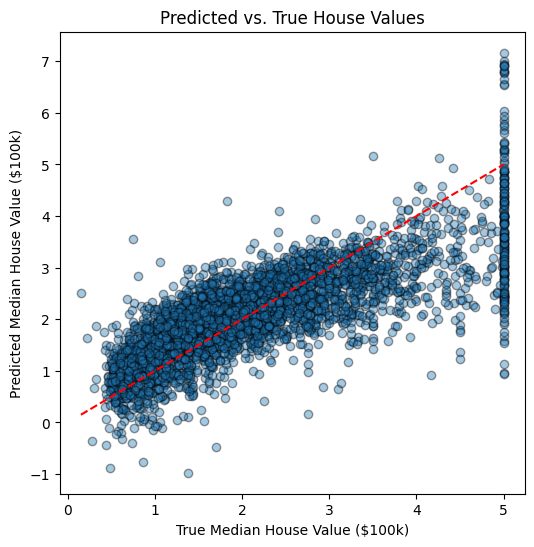

In [ ]:
# --- Scatterplot: Predicted vs True ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True Median House Value ($100k)")
plt.ylabel("Predicted Median House Value ($100k)")
plt.title("Predicted vs. True House Values")
plt.show()

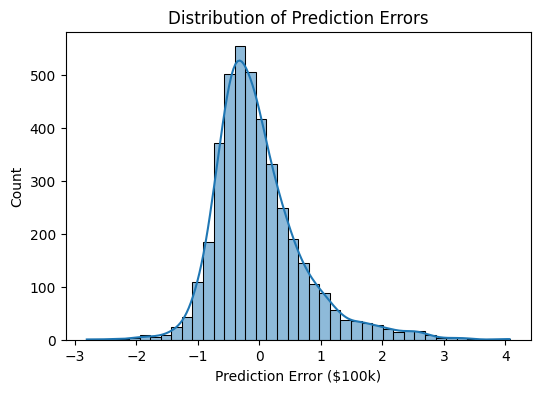

In [ ]:
# --- Histogram of Errors ---
import seaborn as sns
errors = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=40, kde=True)
plt.xlabel("Prediction Error ($100k)")
plt.title("Distribution of Prediction Errors")
plt.show()

In [ ]:
# --- Sort coefficients by importance ---
coef_table = coef_table.sort_values(by="Coefficient", key=abs, ascending=False)
print("\nMost Important Predictors:\n", coef_table)


Most Important Predictors:
       Feature  Coefficient
3   AveBedrms     0.593215
7   Longitude    -0.434166
0      MedInc     0.433333
6    Latitude    -0.421449
2    AveRooms    -0.098643
1    HouseAge     0.009293
5    AveOccup    -0.004745
4  Population    -0.000008


# 5. Classification Analysis
Diagnostic Wisconsin Breast Cancer Database  
https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay)

In [5]:
# Load Breast Cancer Wisconsin Dataset
data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target                  # 0 = malignant, 1 = benign
feature_names = X.columns
label_names = {0: "malignant", 1: "benign"}
print(feature_names)

# Train/Test Split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

# Preprocess Data (fit on train ONLY; then transform both)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_std = scaler.fit_transform(X_train)   # fit on train
X_test_std  = scaler.transform(X_test)        # transform test with train stats

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')


In [6]:
# Support vector machines (SVM) with RBF kernel
svm_clf = SVC(kernel='rbf', probability=True, random_state=0)
svm_clf.fit(X_train_std, y_train)

# Predictions
y_train_pred = svm_clf.predict(X_train_std)
y_test_pred  = svm_clf.predict(X_test_std)
y_train_prob = svm_clf.predict_proba(X_train_std)[:, 1]
y_test_prob  = svm_clf.predict_proba(X_test_std)[:, 1]

In [9]:
# Metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)
train_roc = roc_auc_score(y_train, y_train_prob)
test_roc  = roc_auc_score(y_test, y_test_prob)
train_ap  = average_precision_score(y_train, y_train_prob)
test_ap   = average_precision_score(y_test, y_test_prob)

# Create a DataFrame for a clean table
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "ROC AUC", "Average Precision"],
    "Train": [train_acc, train_roc, train_ap],
    "Test": [test_acc, test_roc, test_ap]
})

metrics_df

,Metric,Train,Test
0,Accuracy,0.989011,0.964912
1,ROC AUC,0.998266,0.993386
2,Average Precision,0.998841,0.996035


TN: 40, FP: 2, FN: 2, TP: 70


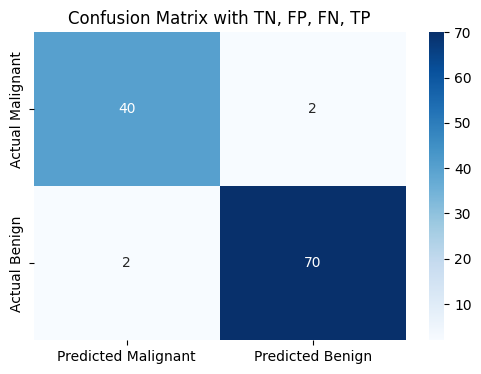

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])

# Map to TN, FP, FN, TP
TN, FP, FN, TP = cm.ravel()
print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")

# Create a labeled DataFrame for display
cm_df = pd.DataFrame(
    [[TN, FP],
     [FN, TP]],
    index=['Actual Malignant', 'Actual Benign'],
    columns=['Predicted Malignant', 'Predicted Benign']
)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix with TN, FP, FN, TP")
plt.show()


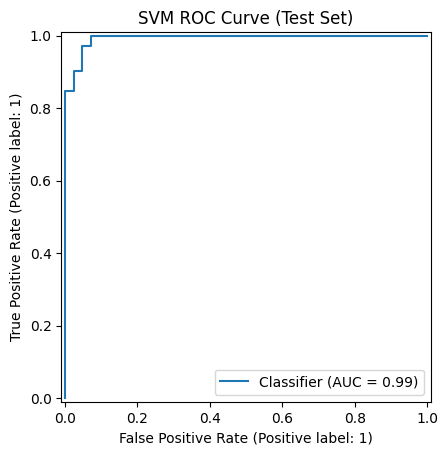

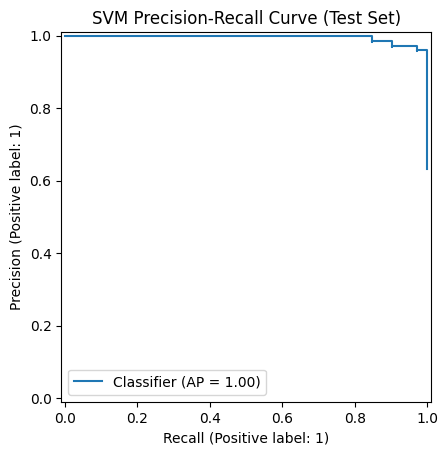

In [16]:
# ROC curve
RocCurveDisplay.from_predictions(y_test, y_test_prob)
plt.title("SVM ROC Curve (Test Set)")
plt.show()

# Precision-Recall curve
PrecisionRecallDisplay.from_predictions(y_test, y_test_prob)
plt.title("SVM Precision-Recall Curve (Test Set)")
plt.show()


In [14]:
#Optional

# Random Forest
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
y_test_rf_prob = rf_clf.predict_proba(X_test)[:, 1]

# Logistic Regression
logreg_clf = LogisticRegression(max_iter=10000, random_state=0)
logreg_clf.fit(X_train_std, y_train)
y_test_log_prob = logreg_clf.predict_proba(X_test_std)[:, 1]
